Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели.  
Цель: В этом проекте вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без, а также придумывать новые признаки для
улучшения качества модели.

## EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [2]:
all_data = pd.read_csv('AB_NYC_2019.csv', index_col='id')

In [3]:
all_data = all_data[~all_data.duplicated()]

In [4]:
data = all_data.drop(['name', 'host_id', 'host_name', 'last_review'], axis=1)

In [5]:
data.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,
2539,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
2595,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
3647,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3831,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
5022,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48895 entries, 2539 to 36487245
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.5+ MB


#### Только один признак имеет пропуски при заполненнии - "reviews_per_month"

In [7]:
data.describe(include = 'all')

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
unique,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,NaN,NaN,0.054530,0.046157,NaN,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000


#### По гео-данным видно, что записи действительно сконцентрированны примерно в одном городе, также видно что некоторые признаки имеют достаточно большие максимальные значения, которые сильно превосходят межквартильный размах

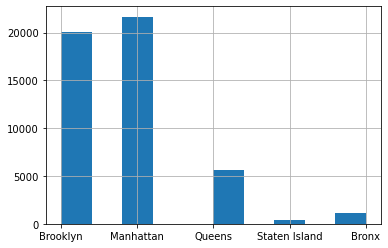

In [8]:
data['neighbourhood_group'].hist()

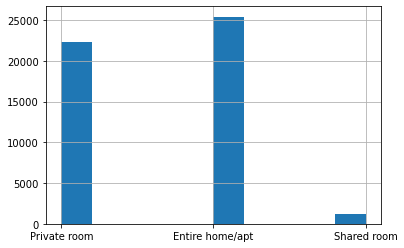

In [9]:
data['room_type'].hist()

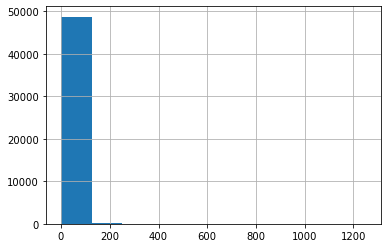

In [10]:
data['minimum_nights'].hist()

In [11]:
data[data['minimum_nights'] > 400].count()

neighbourhood_group               11
neighbourhood                     11
latitude                          11
longitude                         11
room_type                         11
price                             11
minimum_nights                    11
number_of_reviews                 11
reviews_per_month                  5
calculated_host_listings_count    11
availability_365                  11
dtype: int64

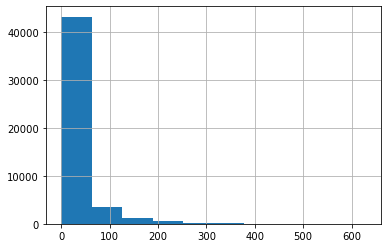

In [12]:
data['number_of_reviews'].hist()

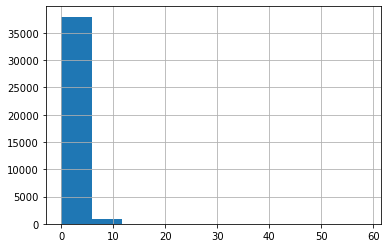

In [13]:
data['reviews_per_month'].hist()

In [14]:
data[data['reviews_per_month'] > 20].count(axis=1)

id
30423106    11
32678719    11
32678720    11
dtype: int64

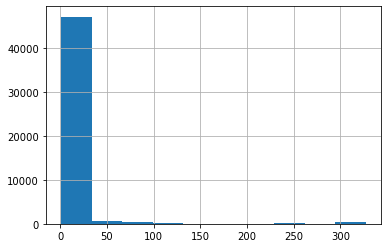

In [15]:
data['calculated_host_listings_count'].hist()

#### Видим значительную концентрацию записей в районе значений 250 и 300, пока не будем их удалять

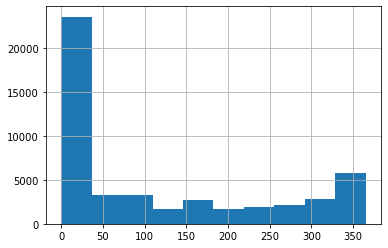

In [16]:
data['availability_365'].hist()

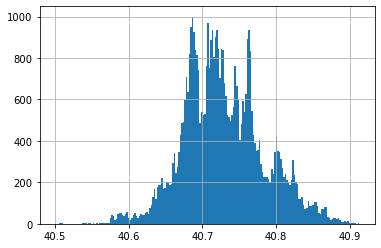

In [17]:
data['latitude'].hist(bins=200)

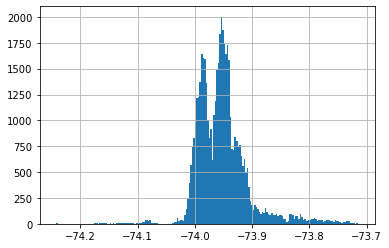

In [18]:
data['longitude'].hist(bins=200)

#### Распределения данных о координатах выглядят как нормальные с 3 и 2 смесями соответственно.

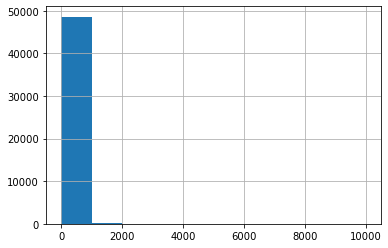

In [19]:
data['price'].hist()

In [20]:
data[data['price'] > 1000].count()

neighbourhood_group               239
neighbourhood                     239
latitude                          239
longitude                         239
room_type                         239
price                             239
minimum_nights                    239
number_of_reviews                 239
reviews_per_month                 107
calculated_host_listings_count    239
availability_365                  239
dtype: int64

#### Варианты с нулевой ценой стоимости аренды - скорее всего ошибка заполнения, уберем эти данные, также уберем единичные выбросы 

#### Цена больше 1000 встречается 239 раз, что для имеющейся выборки достаточно мало, попробуем исключить их

In [21]:
mask = (data['price'] < 1000) & (data['price'] != 0)

In [22]:
data = data[mask]

In [23]:
neighbourhoods_names = data.neighbourhood_group.unique()

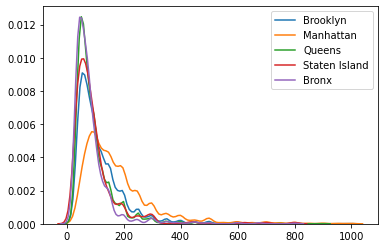

In [24]:
for neighbourhood in neighbourhoods_names:
    sns.kdeplot(data[data['neighbourhood_group'] == neighbourhood]['price'], label = neighbourhood);

In [25]:
room_types = data.room_type.unique()

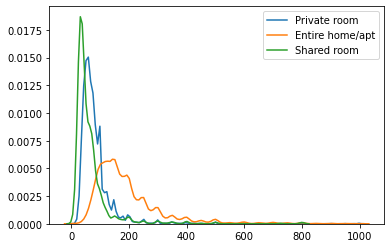

In [26]:
for room_type in room_types:
    sns.kdeplot(data[data['room_type'] == room_type]['price'], label = room_type);

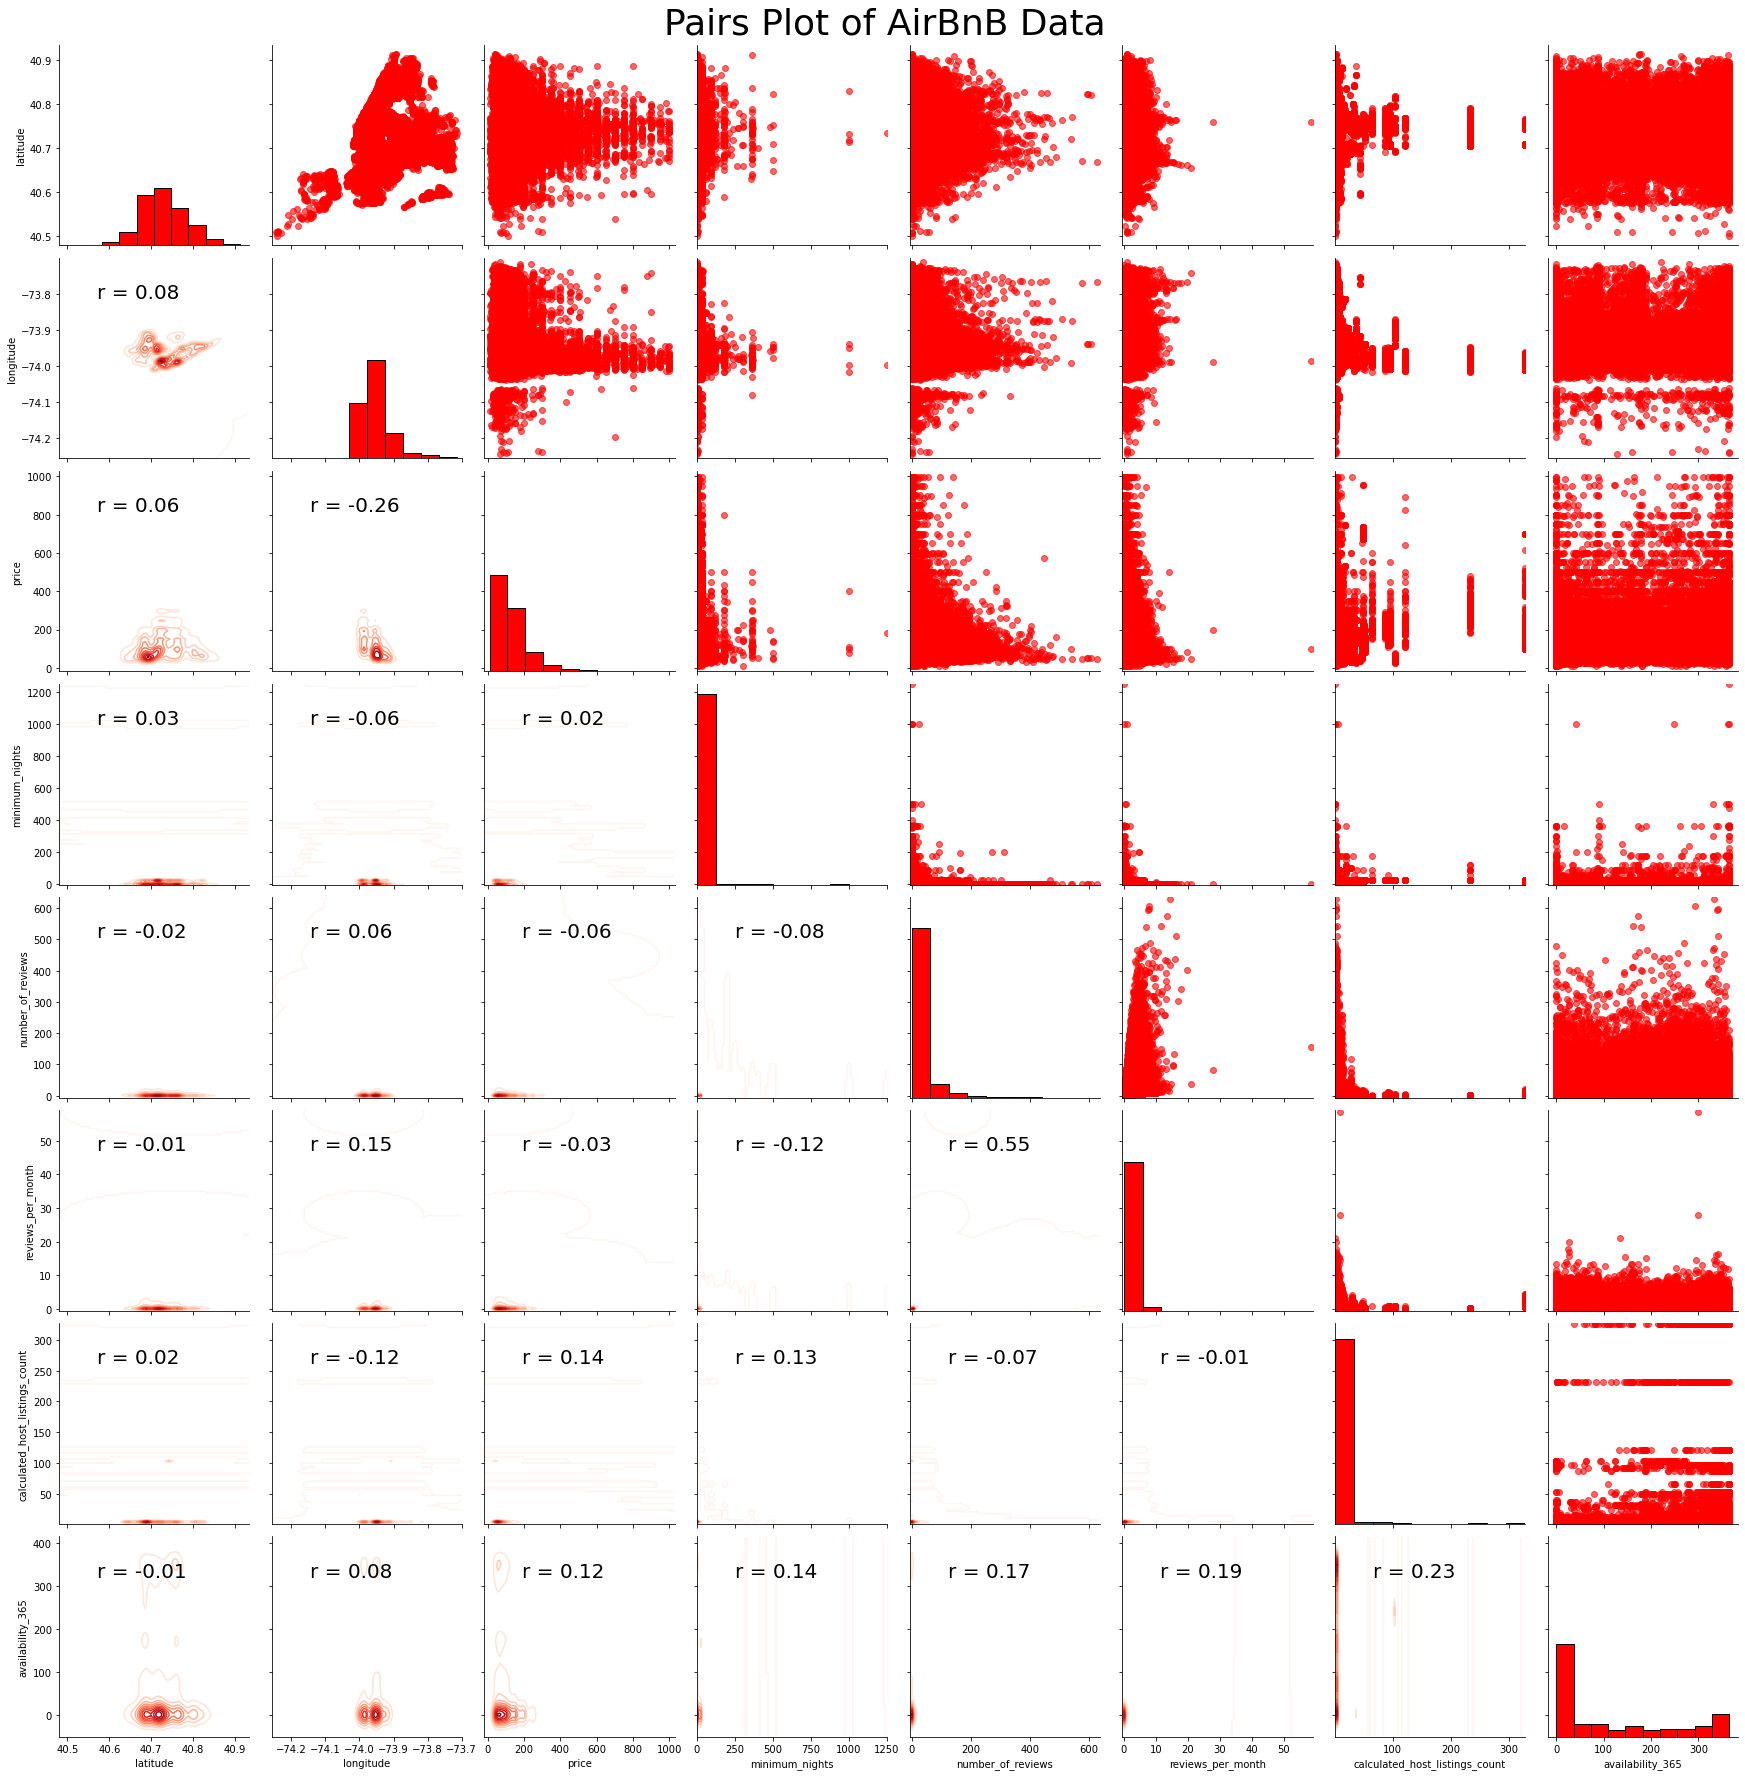

In [27]:
# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data=data, height=3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color='red', alpha=0.6)

# Diagonal is a histogram
grid.map_diag(plt.hist, color='red', edgecolor='black')

# Bottom is correlation and density plot
grid.map_lower(corr_func);
grid.map_lower(sns.kdeplot, cmap=plt.cm.Reds)

# Title for entire plot
plt.suptitle('Pairs Plot of AirBnB Data', size = 36, y = 1.02);

In [28]:
data.corr()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
latitude,1.000000,0.084671,0.063672,0.025215,-0.015315,-0.009905,0.019515,-0.011019
longitude,0.084671,1.000000,-0.264539,-0.064107,0.058173,0.145543,-0.115533,0.084768
price,0.063672,-0.264539,1.000000,0.020715,-0.056773,-0.030065,0.136618,0.117650
minimum_nights,0.025215,-0.064107,0.020715,1.000000,-0.080127,-0.121730,0.129660,0.143985
number_of_reviews,-0.015315,0.058173,-0.056773,-0.080127,1.000000,0.549729,-0.072720,0.173752
reviews_per_month,-0.009905,0.145543,-0.030065,-0.121730,0.549729,1.000000,-0.009520,0.187554
calculated_host_listings_count,0.019515,-0.115533,0.136618,0.129660,-0.072720,-0.009520,1.000000,0.227088
availability_365,-0.011019,0.084768,0.117650,0.143985,0.173752,0.187554,0.227088,1.000000


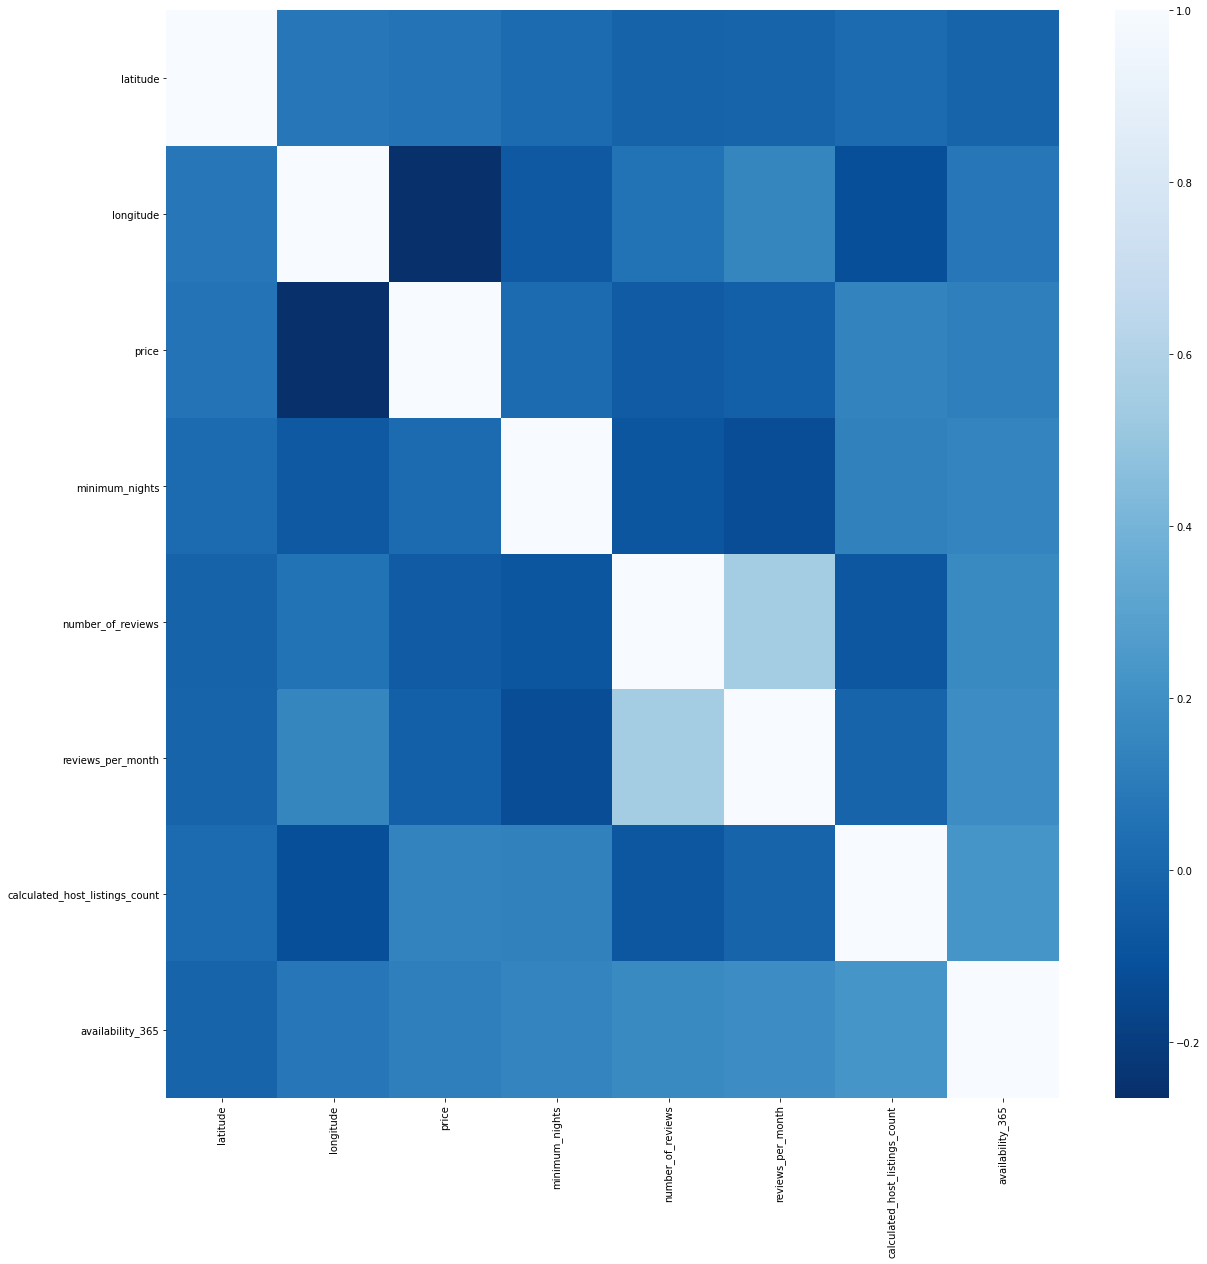

In [29]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), cmap='Blues_r')
plt.show()

## Preprocessing & Feature Engineering

### Попробуем прологарифмировать столбец цен

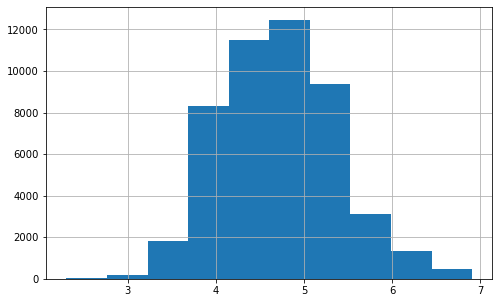

In [30]:
data['price'].apply(np.log).hist(figsize=(8,5))

### Похоже, что данные распределены логнормально

In [31]:
data['log_price'] = data['price'].apply(np.log)

### Добавим признак - расстояние до центра Манхеттана

In [32]:
NY_LAT = 40.78343 
NY_LONG = -73.96625

In [33]:
# Расчет расстояния между двумя точками на сфере (в километрах)
def get_distance(point_1: tuple, point_2: tuple) -> float:
    lat_1 = np.radians(point_1[0])
    long_1 = np.radians(point_1[1])
    
    lat_2 = np.radians(point_2[0])
    long_2 = np.radians(point_2[1])
    
    dlon = long_2 - long_1
    dlat = lat_2 - lat_1
    a = np.sin(dlat / 2)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c*r

In [34]:
data['distance'] = data.apply(lambda x: get_distance((NY_LAT, NY_LONG), (x['latitude'], x['longitude'])), axis=1)

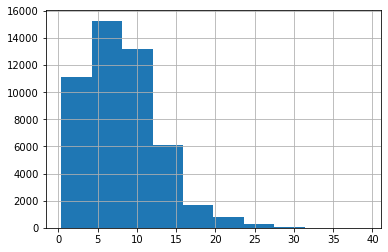

In [35]:
data['distance'].hist()

In [36]:
data[['price', 'log_price']].tail()

,price,log_price
id,,
36484665,70,4.248495
36485057,40,3.688879
36485431,115,4.744932
36485609,55,4.007333
36487245,90,4.499810


#### Посмотрим как распределены цены в зависимости от расстояния, также отметим цветом и метками различные значения районов и типов комнат

In [37]:
plt.rcParams["figure.figsize"] = [15, 10]

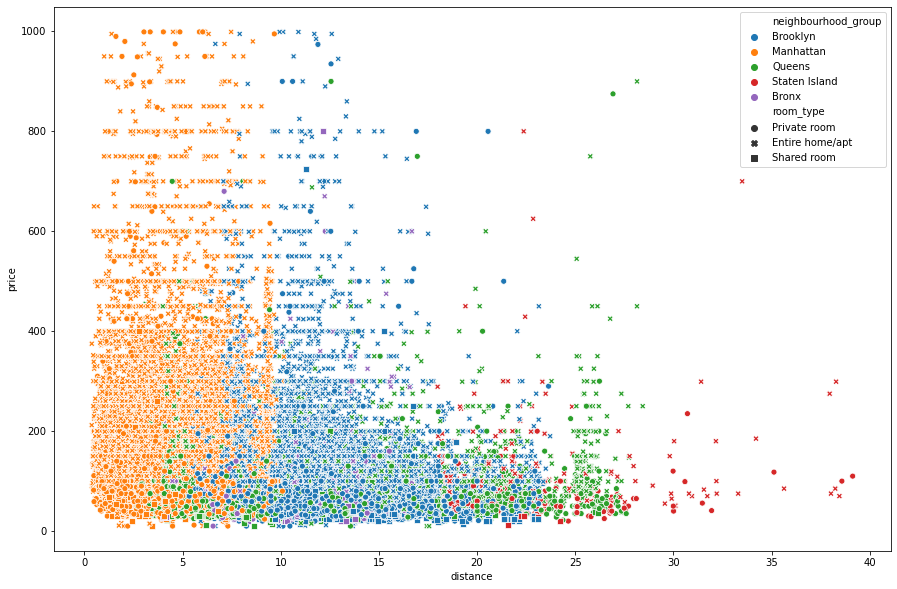

In [38]:
sns.scatterplot(data=data, x='distance', y='price', hue='neighbourhood_group', style='room_type')

### Посмотрим на столбцы - 'number_of_reviews', 'reviews_per_month'. Кажется, они должны быть как-то связаны

In [39]:
data[['number_of_reviews', 'reviews_per_month']]

,number_of_reviews,reviews_per_month
id,,
2539,9,0.21
2595,45,0.38
3647,0,NaN
3831,270,4.64
5022,9,0.10
...,...,...
36484665,0,NaN
36485057,0,NaN
36485431,0,NaN


### Проставим значение 0 в reviews_per_month везде где общее число ревью - 0

In [40]:
data['NEW_reviews_per_month'] = data.apply(lambda x: 0 if x['number_of_reviews'] == 0 and np.isnan(x['reviews_per_month']) else x['reviews_per_month'], axis=1)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48586 entries, 2539 to 36487245
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48586 non-null  object 
 1   neighbourhood                   48586 non-null  object 
 2   latitude                        48586 non-null  float64
 3   longitude                       48586 non-null  float64
 4   room_type                       48586 non-null  object 
 5   price                           48586 non-null  int64  
 6   minimum_nights                  48586 non-null  int64  
 7   number_of_reviews               48586 non-null  int64  
 8   reviews_per_month               38696 non-null  float64
 9   calculated_host_listings_count  48586 non-null  int64  
 10  availability_365                48586 non-null  int64  
 11  log_price                       48586 non-null  float64
 12  distance                  

### Теперь значение частоты ревью присутствует во всех записях

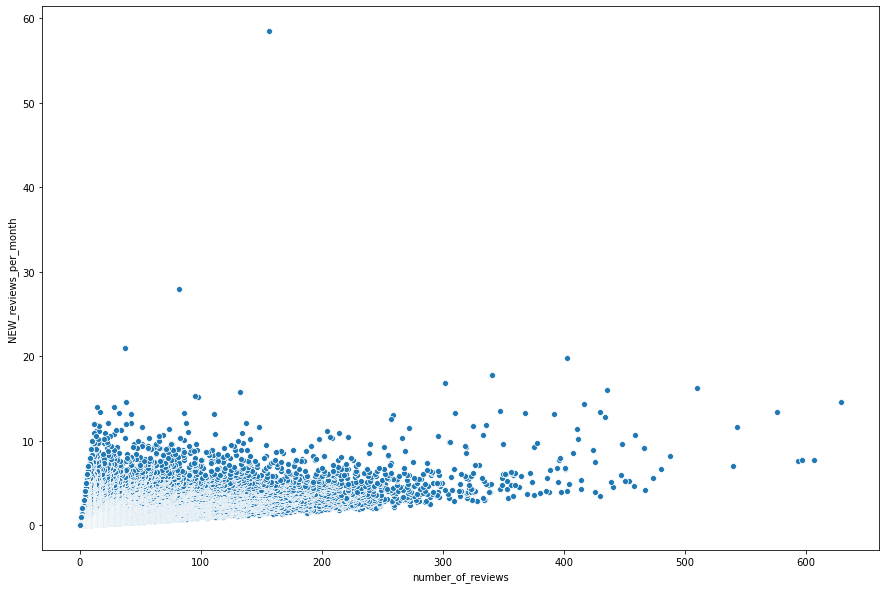

In [43]:
sns.scatterplot(data=data, x='number_of_reviews', y='NEW_reviews_per_month')

### Исключим аномальные значения:

In [44]:
data = data[data['minimum_nights'] < 400]

In [45]:
data = data[data['reviews_per_month'] < 20]

In [47]:
clear_data_1 = data.drop(columns=['latitude', 'longitude', 'price', 'reviews_per_month'], axis=1)

### Преобразуем категориальные признаки

#### попробуем начать c dummy

In [48]:
dummy_data_1 = pd.get_dummies(clear_data_1, drop_first=True)

In [82]:
dummy_data_1.head(1)

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance,NEW_reviews_per_month,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,...,neighbourhood_Whitestone,neighbourhood_Williamsbridge,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,room_type_Private room,room_type_Shared room
id,,,,,,,,,,,,,,,,,,,,,
2539,1,9,6,365,5.003946,15.124636,0.21,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## Modeling

In [84]:
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def dataframe_metrics(y_test,y_pred):
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred),
       mean_absolute_percentage_error(y_test, y_pred)
    ]
    return stats


measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [51]:
def get_encoded_data(input_data: pd.DataFrame, target_name: str, encoder_slug: str, **kwargs) -> pd.DataFrame:
    if encoder_slug == 'dummy':
        return pd.get_dummies(input_data, drop_first=True)
    else:
        X_train, _, y_train, _ = train_test_split(
            input_data, 
            input_data[target_name], 
            test_size=0.3
        )
        if encoder_slug == 'ordinal':
            ord_enc = ce.OrdinalEncoder(cols=kwargs['encoded_cols']).fit(X_train, y_train)
            return ord_enc.transform(input_data)
        elif encoder_slug == 'catboost':
            catboost_enc = ce.CatBoostEncoder(cols=kwargs['encoded_cols']).fit(X_train, y_train)
            return catboost_enc.transform(input_data)
    raise ValueError(f'{encoder_slug} is not available encoder slug')

In [83]:
def show_reuslts(
    data: pd.DataFrame, 
    target_name: str, 
    scaler_class: type, 
    encoder_slug: str, 
    encoded_cols: list = None
) -> dict:
    data = data.copy()
    measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
    measured_metrics.set_index("error_type")    
    
    # Encode string columns
    data = get_encoded_data(data, target_name, encoder_slug, encoded_cols=encoded_cols)
    
    
    # Split encoded data
    X_train, X_test, y_train, y_test = train_test_split(
        data.drop([target_name], axis=1), 
        data[target_name], 
        test_size=0.3
    )
    
    # Base line
    y_median = np.median(y_train)
    y_pred_naive = np.ones(len(y_test)) * y_median
    measured_metrics['naive_baseline'] = dataframe_metrics(y_test, y_pred_naive)
    
    # Liner Models
    scaler = scaler_class()

    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[X_train.columns] = scaler.fit_transform(X_train)
    X_test_scaled[X_train.columns] = scaler.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    measured_metrics['lr'] = dataframe_metrics(y_test, lr.predict(X_test_scaled))
    
    # Lasso
    lasso_cv = LassoCV(cv=5)
    lasso_cv.fit(X_train_scaled, y_train)
    measured_metrics['lasso_cv'] = dataframe_metrics(y_test, lasso_cv.predict(X_test_scaled))
    
    # Ridge
    ridge_cv = RidgeCV(cv=5)
    ridge_cv.fit(X_train_scaled, y_train)
    measured_metrics['ridge_cv'] = dataframe_metrics(y_test, ridge_cv.predict(X_test_scaled))
    
    # Elastic
    elastic_cv = ElasticNetCV()
    elastic_cv.fit(X_train_scaled, y_train)
    measured_metrics['elastic_cv'] = dataframe_metrics(y_test, elastic_cv.predict(X_test_scaled))

    
    # Trees
    # Random Forest
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    measured_metrics['rf'] = dataframe_metrics(y_test, rf.predict(X_test))
    
    # RandomizedSearchCV
    params = {
        'n_estimators':[10, 25, 50],
        'max_depth':[2, 5, 7, 10],
        'max_features':[
            'auto', 
            X_train.shape[1]//2, 
            'sqrt',
            'log2'
        ]
    }

    rscv = RandomizedSearchCV(
        estimator=RandomForestRegressor(),
        param_distributions = params,
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    rscv.fit(X_train, y_train)
    
    rscv.best_estimator_.fit(X_train, y_train)
    measured_metrics['rf_cv'] = dataframe_metrics(y_test, rscv.best_estimator_.predict(X_test))
    
    return measured_metrics

### Посмотрим какая точность достигается с помошью различных способов масштабирования данных

In [67]:
show_reuslts(data=dummy_data_1, target_name='log_price', scaler_class=StandardScaler,  encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.2s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.517368,5.574886e+09,0.311985,0.312034,0.312021,0.294264,0.299635
1,RMSE,0.646424,5.573327e+11,0.416949,0.417125,0.416979,0.396763,0.400086
2,R2,-0.016492,-7.556098e+23,0.577104,0.576746,0.577043,0.617059,0.610619
3,MAPE,11.110874,1.269855e+11,6.669450,6.669472,6.670306,6.280443,6.406903


In [68]:
show_reuslts(data=dummy_data_1, target_name='log_price', scaler_class=RobustScaler, encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.8s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.521089,5.151004e+03,0.319480,0.309532,0.320464,0.294769,0.299383
1,RMSE,0.646041,3.203798e+05,0.422016,0.409231,0.423143,0.394707,0.396988
2,R2,-0.019070,-2.506195e+11,0.565146,0.591095,0.562822,0.619605,0.615197
3,MAPE,11.156565,1.147109e+05,6.830643,6.609291,6.856982,6.290073,6.391610


In [69]:
show_reuslts(data=dummy_data_1, target_name='log_price', scaler_class=MinMaxScaler, encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.0s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.523491,5.878267e+06,0.311870,0.310735,0.312168,0.295181,0.298866
1,RMSE,0.653898,4.478105e+08,0.417328,0.415775,0.417554,0.397617,0.401867
2,R2,-0.016383,-4.766794e+17,0.586007,0.589082,0.585558,0.624190,0.616113
3,MAPE,11.230572,1.355373e+08,6.668211,6.642661,6.675557,6.308482,6.385764


### По данным видо небольшое преимущество стандартного масштабирования

### Мы работали с логарифмированнми ценами, попробуем теперь посмотреть на точность предсказания для нелогарифмированных цен

In [70]:
clear_data_2 = data.drop(columns=['latitude', 'longitude', 'log_price', 'reviews_per_month'], axis=1)

In [71]:
clear_data_2.head(1)

,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance,NEW_reviews_per_month
id,,,,,,,,,,
2539,Brooklyn,Kensington,Private room,149,1,9,6,365,15.124636,0.21


In [72]:
dummy_data_2 = pd.get_dummies(clear_data_2, drop_first=True)

In [73]:
show_reuslts(data=dummy_data_2, target_name='price', scaler_class=StandardScaler, encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.5s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,66.927888,6.316507e+11,48.436411,48.663235,48.290520,45.097143,45.623962
1,RMSE,108.622206,3.402634e+13,80.967754,80.943696,80.941611,77.252611,77.755800
2,R2,-0.098533,-1.077969e+23,0.389620,0.389983,0.390014,0.444349,0.437087
3,MAPE,54.391696,1.349814e+12,39.587454,39.875583,39.705554,35.757859,36.978734


In [74]:
show_reuslts(data=dummy_data_2, target_name='price', scaler_class=RobustScaler, encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.7s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,67.342121,9.075991e+06,49.865443,49.122502,57.041857,45.533278,45.508367
1,RMSE,111.413950,6.914117e+08,84.154410,82.706385,92.115621,77.154788,77.981621
2,R2,-0.115869,-4.297415e+13,0.363369,0.385089,0.237218,0.464870,0.453339
3,MAPE,52.225879,7.873146e+06,40.780315,39.519849,54.884996,35.821209,36.317798


In [75]:
show_reuslts(data=dummy_data_2, target_name='price', scaler_class=MinMaxScaler, encoder_slug='dummy')

start encode
finish encode
finish baseline
start fit
finish fit
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.7s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,66.499957,1.653084e+07,48.186028,48.292146,49.518462,45.366230,44.978580
1,RMSE,109.287179,9.351328e+08,80.833684,80.736800,83.478123,77.193441,76.365561
2,R2,-0.113502,-8.152657e+13,0.390832,0.392291,0.350322,0.444463,0.456315
3,MAPE,51.951144,1.953265e+07,38.749765,38.985849,42.395602,35.431446,35.854807


### Сравним точность логарифмированных данных и обычных

### Рассмотрим подробнее лучший вариант - RandomForest, с MAE ~ 0.31

### Учитывая, что мы предсказыает логарифм цены, то в абсолютных числах ошибку можно вычислить так:
#### для нашего доверительного интервала справедливо
```
y_pred - предсказанное с помощью нашей модели значение
y_true - истинное значение цены для входных данных

ln(y_pred) - 0.31 < y_true < ln(y_pred) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_true) + 0.31
ln(y_pred) - 0.31 < ln(y_true) < ln(y_pred) + 0.31
ln(y_pred) - log(e^0.31) < ln(y_true) < ln(y_pred) + ln(e^0.31)
ln(y_pred/e^0.31) < ln(y_true) < ln(y_pred*e^0.31)

e^0.31 ~ 1.36

```
### Таким образом итоговая погрешность составила +- 36%

### Теперь посмотрим как точность предсказания зависит от энкодинга категориальных признаков

In [76]:
clear_data_1.head(1)

,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,log_price,distance,NEW_reviews_per_month
id,,,,,,,,,,
2539,Brooklyn,Kensington,Private room,1,9,6,365,5.003946,15.124636,0.21


In [78]:
encoded_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']

In [79]:
show_reuslts(
    data=clear_data_1, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='ordinal', 
    encoded_cols=encoded_cols
)

start encode
finish encode
finish baseline
start fit
finish fit


/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.520163,0.373202,0.373276,0.373215,0.373298,0.293743,0.297308
1,RMSE,0.649297,0.518481,0.518435,0.518479,0.518435,0.397835,0.399849
2,R2,-0.015168,0.352683,0.352797,0.352688,0.352798,0.618885,0.615015
3,MAPE,11.168656,8.136034,8.137654,8.136333,8.138150,6.285080,6.357400


In [80]:
show_reuslts(
    data=clear_data_1, 
    target_name='log_price', 
    scaler_class=StandardScaler, 
    encoder_slug='catboost', 
    encoded_cols=encoded_cols
)

start encode
finish encode
finish baseline
start fit
finish fit


/Users/user/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished


,error_type,naive_baseline,lr,lasso_cv,ridge_cv,elastic_cv,rf,rf_cv
0,MAE,0.517070,0.309552,0.309544,0.309547,0.309538,0.291198,0.290295
1,RMSE,0.642267,0.413147,0.413153,0.413145,0.413150,0.390808,0.388372
2,R2,-0.010317,0.581942,0.581932,0.581948,0.581937,0.625930,0.630578
3,MAPE,11.163624,6.658342,6.658351,6.658280,6.658293,6.268912,6.250998


### Видно, что линейные модели стали предсказывать цену намного лучше после энкодинга с помощью алгоритма "catboost"